# Basic Settings : 사용할 때는 무시하세요

In [1]:
# !pip install matplotlib
# !pip install forallpeople

In [2]:
import csv
from dataclasses import dataclass, field, asdict, astuple
from typing import List
from collections import namedtuple
from functools import reduce
from functools import partial
# import forallpeople as si ## 단위 변환 관련 패키지(아직 미사용)
import math
import matplotlib.pyplot as plt
import numpy as np
# import matplotlib.transforms as transforms

In [3]:
#################################Module For Functional Programing#############################################
curry = lambda f: lambda a,*args: f(a, *args) if (len(args)) else lambda *args: f(a, *args)

filter = curry(filter)
map = curry(map)

def _take(length, iter):
    res = []
    for a in iter:
        res.append(a)
        if len(res) == length:
            return res
        
take = curry(_take)
reduce = curry(reduce)

go = lambda *args: reduce(lambda a,f: f(a), args) ## 함수도 축약 가능 ##
##############################################################################################################

In [4]:
## 함수형 프로그래밍 코드 사용 예제

add = curry(lambda a,b: a + b)

example = lambda _list: go\
(_list,
    filter(lambda a: not a % 2),
    filter(lambda a: not a % 4),
    map(lambda a: a ),
    reduce(add)
)

In [5]:
example([1,2,3,4,5,6])

4

# Definition Code Part

In [6]:
## 사용 예시
#######################################################################################
    ####### 공통 입력부 #######
input_path = 'Section Profile.csv'

input_dsgnMode = "LRFD"

input_fy = 344.738 ## 50 ksi
input_fu = 448.159 ## 65 ksi
input_E = 199900 ## 29000

# input_DL = 6.567  ## 휨 검토때
# input_LL = 10.945
# input_length = 10670

input_DL = 622.751 ##140 kips ## 압축 검토때
input_LL = 1868.253 ## 420 kips

input_Pu = 1779 ## kN (400 kip)
input_Mux = 338.954 ## kN*m
input_Muy = 108.465 ## kN*m
input_length = 4267 ## 14 ft

    ####### 휨 입력부 #######
input_cb_mode = "Cb고려"
input_table_mode = "continuous"
input_brace_idx = 2

    ####### 압축 입력부 #######
input_Comp_mode = "recommended" ### 압축 유효길이 팩터 테이블 산정 모드
input_cond = "d"  ### 압축 유효길이 팩터 테이블 상 지점 조건
input_effLength = [4267] ### 압축 유효길이

    ####### 인장 입력부 #######
input_dia_bolt=20
input_length_bolt=228
input_n_bolt=4
input_gap_bolt=2

# input_dia_bolt = input_length_bolt = input_n_bolt = input_gap_bolt = None

#######################################################################################

<br>

## 0. 단면 정보 import (선언부)

In [7]:
def importCSV(_path):
    with open(_path,'r') as f:
        reader  = csv.reader(f) # csv의 행별로 읽어옴
        res = [x for x in reader]
        
    return res

In [8]:
def exportCSV(_filename, _datas):
    f = open(_filename, 'w', newline='') # 자동줄바꿈 방지 header 이후 첫행 빈행 생성 방지
    csv_writer = csv.writer(f)
    
    for x in _datas:
        csv_writer.writerow(x)
    f.close()

In [9]:
dfSectionProfile = importCSV(input_path)
dfHeader = dfSectionProfile.pop(0) #pop(0)의 의미 첫행을 값을 반환하고 나머지 리스트는 저장
dfSectionProfile
# dfSectionProfile[14]

[['W44X335', 'W', '1120', '404', '26.2', '45', '65'],
 ['W44X290', 'W', '1110', '401', '22', '40.1', '59.9'],
 ['W44X262', 'W', '1100', '401', '19.9', '36.1', '55.9'],
 ['W44X230', 'W', '1090', '401', '18', '31', '51.1'],
 ['W40X655', 'W', '1110', '429', '50', '89.9', '120'],
 ['W40X593', 'W', '1090', '424', '45.5', '82', '112'],
 ['W40X503', 'W', '1070', '417', '39.1', '70.1', '100'],
 ['W40X431', 'W', '1050', '411', '34', '59.9', '89.9'],
 ['W40X397', 'W', '1040', '409', '31', '55.9', '85.9'],
 ['W40X372', 'W', '1030', '409', '29.5', '52.1', '82'],
 ['W40X362', 'W', '1030', '406', '28.4', '51.1', '81'],
 ['W40X324', 'W', '1020', '404', '25.4', '46', '75.9'],
 ['W40X297', 'W', '1010', '401', '23.6', '41.9', '71.9'],
 ['W40X277', 'W', '1010', '401', '21.1', '40.1', '70.1'],
 ['W40X249', 'W', '1000', '401', '19.1', '36.1', '66'],
 ['W40X215', 'W', '991', '401', '16.5', '31', '61'],
 ['W40X199', 'W', '983', '401', '16.5', '27.2', '57.2'],
 ['W40X392', 'W', '1060', '315', '36.1', '64', '9

## 1. 단면 자료형 Setter (선언부)

In [10]:
def makeSectionForm(args):
    
    Form = namedtuple('SectionForm', ['ID','shape','h','bf','tw','tf','k'])
    form = \
        Form(ID=args[0], shape=args[1], 
            h=float(args[2]), bf=float(args[3]), 
            tw=float(args[4]), tf=float(args[5]), k=float(args[6]))        
    
    return form


### 예시 ###
# sForm = makeSectionForm(dfSectionProfile[294])
# sForm

# targetSection = makeSectionForm(dfSectionProfile[160])
_targetSection = list(filter(lambda x: makeSectionForm(x).ID == "W14X99", dfSectionProfile))[0]
targetSection = makeSectionForm(_targetSection)
targetSection

SectionForm(ID='W14X99', shape='W', h=361.0, bf=371.0, tw=12.3, tf=19.8, k=35.1)

<br><br><br>
## 2. 단면 속성 Setter (선언부)

In [11]:
def setSectionProp(sForm, mProp):
    E = mProp.E
    fy = mProp.fy
    
    def defineC():
        if _shape == "W" or _shape == "H": return 1
        elif _shape == "C": return (_h0/2) * (_Iy/_Cw)**0.5
        else: return 1 ## 임시 대처     
    
    
    Prop = namedtuple(
        'SectionProperty', 
        ['ID', 'h', 'bf', 'tw', 'tf', 'k', 'shape', 'Area', 'Weight', 
         'Ix', 'Sx', 'Zx', 'rx', 'Iy', 'Sy', 'Zy', 'ry', 
         'Cw', 'J', 'rts', 'h0', 'Slnd_Flange', 'Slnd_Web', 'C'])
       
    def chkSlenderness(shape, mode):
        if _shape == 'H' or 'W':
            if mode == 'flange':
                if _bf/(2*_tf) < 0.56*(E/fy)**0.5:
                    return "nonslender"
                else:
                    return "slender"

            elif mode == 'web':
                if (_h-2*_k)/_tw < 1.49*(E/fy)**0.5:
                    return "nonslender"
                else:
                    return "slender"
            else:
                pass

        elif _shape == 'BH':
                if mode == 'flange':
                    _kc = min(4/(_h/_tw)**0.5, 0.35)
                    if _bf/(2*_tf) < 0.64*(_kc*E/fy)**0.5:
                        return "nonslender"
                    else:
                        return "slender"

                elif mode == 'web':
                    if (_h-2*_self.k)/_tw < 1.49*(E/fy)**0.5:
                        return "nonslender"
                    else:
                        return "slender"
                else:
                    pass
                
    (_ID,_h,_bf,_tw,_tf,_k,_shape) = (sForm.ID,sForm.h,sForm.bf,sForm.tw,sForm.tf,sForm.k,sForm.shape)             
    _Area = 2*_tf*_bf+(_h-2*_tf)*_tw
    _Weight = _Area*77.22/10**6
    _Ix = (2*(_bf*_tf**3/12+_bf*_tf*((_h-2*_tf)/2+_tf/2)**2)+_tw*(_h-2*_tf)**3/12) 
    _Sx = _Ix/(_h/2)
    _Zx = _bf*_tf*(_h-_tf)+0.25*(_h-2*_tf)**2*_tw
    _rx = (_Ix/_Area)**0.5
    _Iy = 2*(_tf*(_bf)**3/12)+(_h-2*_tf)*(_tw)**3/12
    _Sy = _Iy/(_bf/2)
    _Zy = 0.5*(_bf)**2*_tf+0.25*(_h-2*_tf)*(_tw)**2
    _ry = (_Iy/_Area)**0.5
    _Cw = (_h-_tf)**2*_bf**3*_tf/24
    _Slnd_Flange = chkSlenderness(_shape, 'flange')
    _Slnd_Web = chkSlenderness(_shape, 'web')
    (_J,_rts,_h0,_C) = ((2*_bf*_tf**3+(_h-_tf)*_tw**3)/3, ((_Iy*_Cw)**0.5/_Sx)**0.5, _h-_tf, defineC()) 
    
    
    prop = Prop(
        ID= _ID, h= _h, bf= _bf, tw= _tw, tf= _tf, k= _k, shape= _shape, Area= _Area, Weight= _Weight,
        Ix= _Ix, Sx= _Sx, Zx= _Zx, rx= _rx, Iy= _Iy, Sy= _Sy, Zy= _Zy, ry= _ry,
        Cw= _Cw, J= _J, rts= _rts, h0= _h0, Slnd_Flange= _Slnd_Flange, Slnd_Web= _Slnd_Web, C= _C)
    
    return prop

In [12]:
sProp = setSectionProp(targetSection, mProp)
# sProp

NameError: name 'mProp' is not defined

<br><br><br>
## 3. 재료 속성 Setter (선언부)

In [ ]:
def setMaterialProp(_fy, _fu, _E):
    Prop = namedtuple('MaterialProperty', ['fy', 'fu', 'E'])
    prop = Prop(fy=_fy, fu=_fu, E=_E)
    
    return prop

### 예시 ###
mProp = setMaterialProp(344.738, 448.159, 199900)
mProp

## 4-1. 프레임 해석 // 추후 구현 예정 //

In [ ]:
def setRequiredStrength(_DL, _LL, _Pu, _Mux, _Muy):
    def calcPu(_DL, _LL): ## 추후 구현
        pass
    def calcMu(_DL, _LL): ## 추후 구현
        pass
    _Load = namedtuple('LoadInform', ['DL', 'LL'])
    RqStr = namedtuple('requiredStrength', ['Load', 'Pu', 'Mux', 'Muy'])
    
    return RqStr(Load= _Load(DL=_DL, LL=_LL), Pu=_Pu, Mux=_Mux, Muy=_Muy)
    
rqStr = setRequiredStrength(input_DL, input_LL, input_Pu, input_Mux, input_Muy)
rqStr

## 4-2. 디자인 베이스 Setter (선언부)

In [ ]:
def setDesignBase(_dsgnMode, _rqStr, _length, _useMode):
    
    Base = namedtuple('DesignBase', ['DL', 'LL', 'length', 'Pr', 'Mrx', 'Mry'])

    def calcRequired(_dsgnMode):
        _DL = _rqStr.Load.DL
        _LL = _rqStr.Load.LL
        def _calcStr():
            if _dsgnMode == "LRFD":
                result = 1.2*_DL + 1.6*_LL
            elif _dsgnMode == "ASD":
                result = _DL + _LL
            else:
                result = "check the DesignMode"
            return result
        
        def _calcMoment():
            result = ((_calcStr() * _length**2) / 8) / 1000**2
            return result

        return (_calcStr(), _calcMoment())
    
    if _useMode == "useLoad":
        base = Base(
            DL=_rqStr.Load.DL, LL=_rqStr.Load.LL,
            length=_length, Pr=_calcRequired(_dsgnMode)[0], Mrx=calcRequired(_dsgnMode)[1], Mry=calcRequired(_dsgnMode)[1])
    elif _useMode == "usePuMu":
        base = Base(
            DL=_rqStr.Load.DL, LL=_rqStr.Load.LL,
            length=_length, Pr=_rqStr.Pu, Mrx=_rqStr.Mux, Mry=_rqStr.Muy)
    
    return base

### 예시 ###
dBase = setDesignBase(input_dsgnMode, rqStr, input_length, "usePuMu")
dBase

## 5. 서브 디자인 베이스 Setter (선언부)

In [ ]:
def setFlexureBase(cb_mode, table_mode, _brace_idx):
    Base = namedtuple('SubBase_flx', ['brace_idx', 'Cb'])

    def findCb():
        _none = {
            "1p": [[1.32]],
            "2p": [[1.14]],
            "3p": [[1.14]],
            "continuous": [[1.14]] }

        _atLoad = {
            "1p": [1.67, 1.67],
            "2p": [1.67, 1.00, 1.67],
            "3p": [1.67, 1.11, 1.11, 1.67],
            "continuous": 
                [[1.30, 1.30], 
                [1.45, 1.01, 1.45], 
                [1.52, 1.06, 1.06, 1.52], 
                [1.56, 1.12, 1.00, 1.12, 1.56]] }
        if cb_mode == "Cb고려":
            if _brace_idx == 0:
                result = _none[table_mode][0]#[_brace_idx]
            else:
                if table_mode == "continuous":
                    result = _atLoad[table_mode][_brace_idx-1]
                else:
                    result = _atLoad[table_mode]
        elif cb_mode == "Cb미고려":
            result = [ 1.00 ]

        return result
    
    base = Base(brace_idx= _brace_idx, Cb=findCb())    
    return base

### 예시 ###
fBase = setFlexureBase("Cb고려", "continuous", 2)
fBase

In [ ]:
def setCompressureBase(mode, cond, *_length):
    Base = namedtuple('SubBase_Comp', ['unbracedLength_x', 'unbracedLength_y', 'factorK'])
    
    def EffectiveLength():
        
        if len(_length) == 1:
            _unbracedLength_x = _length[0]
            _unbracedLength_y = _length[0]
        elif len(_length) == 2:
            _unbracedLength_x = _length[0]
            _unbracedLength_y = _length[1]
        
        EffectiveLength = [_unbracedLength_x, _unbracedLength_y]
        return EffectiveLength
    
    def factorK():
        _factorTable = {
            "a": (0.5, 0.65),
            "b": (0.7, 0.80),
            "c": (1.0, 1.2),
            "d": (1.0, 1.0),
            "e": (2.0, 2.1),
            "f": (2.0, 2.0),
        }
        
        if mode == "theoretical":
            factorK = _factorTable[cond][0]
            
        elif mode == "recommended":
            factorK = _factorTable[cond][1]
            
        else:
            factorK = 'Please select mode("theoretical" or "recommended")'

        return factorK
    
    base = Base(unbracedLength_x= EffectiveLength()[0], unbracedLength_y= EffectiveLength()[1], factorK= factorK())    
    return base

### 예시 ###
cBase = setCompressureBase("recommended", "d", 4267)
cBase

In [ ]:
def setTensileBase(_dia_bolt, _len_bolt, _n_bolt, _gap_bolt):
    
    Base = namedtuple('SubBase_Tensile', ['dia_bolt', 'length_bolt', 'n_bolt', 'gap_bolt'])
    base = Base(dia_bolt=_dia_bolt, length_bolt=_len_bolt, n_bolt=_n_bolt, gap_bolt=_gap_bolt)
    
    return base

### 예시 ###
tBase = setTensileBase(20, 228, 4, 2)
tBase

In [ ]:
def setCombinedBase(_cBase, _fBase):
    Base = namedtuple('SubBase_Combined', ['cBase', 'fBase'])
    return Base(cBase=_cBase, fBase=_fBase)

### 예시 ###
comBase = setCombinedBase(cBase, fBase)
comBase

## 6.a 서브 디자인 결과 Checker_휨 (선언부)

In [ ]:
def checkFlexure(_dsgnMode, _sProp, _mProp, _dBase, _subBase):
    ResultForm = namedtuple('flexResult', ['Mcx', 'Mcy'])
    
    def findLp():
        return 1.76 * _sProp.ry * (_mProp.E/_mProp.fy)**0.5
    
    def findLr():
        return 1.95*_sProp.rts*_mProp.E/(0.7*_mProp.fy)*(_sProp.J/(_sProp.Sx*(_sProp.h0))+((_sProp.J/(_sProp.Sx*(_sProp.h0)))**2+6.76*(0.7*_mProp.fy/_mProp.E)**2)**0.5)**0.5
    
    def findMp():
        ### for Strong Axis ###
        Mp_x = _mProp.fy * _sProp.Zx
        ### for Weak Axis ###
        Mp_y = min([(_mProp.fy * _sProp.Zy), (1.6*_mProp.fy*_sProp.Sy)])
        
        return {"Mp_x": Mp_x, "Mp_y": Mp_y}
    
    def findMn(): ### for Strong Axis ###
        (Mp,Lp,Lr,Lb) = (findMp()["Mp_x"], findLp(), findLr(), _dBase.length/(_subBase.brace_idx+1))
        
        if Lb <= Lp:
            Mn = Mp
        elif Lp < Lb <= Lr:
            Mn = min(map(lambda x: x * (Mp-(Mp-0.7*_mProp.fy*_sProp.Sx)*((Lb-Lp) / (Lr-Lp))), _subBase.Cb))
        elif Lb > Lr:
            Fcr = min(map(lambda x: (x * (math.pi**2 * _mProp.E)/((Lb/_sProp.rts)**2)) * (1 + 0.078*(((_sProp.J*_sProp.C)/(_sProp.Sx*_sProp.h0))*(Lb/_sProp.rts)**2))**0.5 ,_subBase.Cb))
            Mn = min((Fcr)*_sProp.Sx, Mp)
        
        return Mn / 1000**2
    
    def findMn_weekAxis():
        Mn = findMp()["Mp_y"] ## 약축 휨 Buckling 무시: 해당 부재 많지 않고, 적용하는 경우에도 강도 감소 크지 않음. Yielding 설계
        return Mn / 1000**2
    
    
    def calcNominal(_Mn):
        if _dsgnMode == "LRFD":
            result = 0.90 * _Mn
        elif _dsgnMode == "ASD":
            result = _Mn / 1.67
        else:
            result = "check the DesignMode"
            
        return result
        
    return ResultForm(Mcx=calcNominal(findMn()), Mcy=calcNominal(findMn_weekAxis()))

### 예시
fCheck = checkFlexure(input_dsgnMode, sProp, mProp, dBase, fBase)
fCheck

## 6.b 서브 디자인 결과 Checker_압축 (선언부)

In [ ]:
def checkCompressure(_dsgnMode, _sProp, _mProp, _dBase, _subBase):
    
    def find_Lc():
        Lc_x = _subBase.factorK * _subBase.unbracedLength_x
        Lc_y = _subBase.factorK * _subBase.unbracedLength_y
        return (Lc_x, Lc_y)

    def find_r(): ## 회전 반경
        rx = _sProp.rx
        ry = _sProp.ry
        return (rx, ry)

    def find_Lc_r(): ## 세장비 (effective slenderness ratio)
        Lc_rx = find_Lc()[0]/find_r()[0]
        Lc_ry = find_Lc()[1]/find_r()[1]

        def chk_IsLcExceed():
            if Lc_rx < 200 and Lc_ry < 200:
                return (Lc_rx, Lc_ry)
            else:
                return (Lc_rx, Lc_ry, "ratio exceed 200")

        return chk_IsLcExceed()

    def find_Fe(): ## 탄성 좌굴 응력
        r = find_r()
        Lc_rx = find_Lc_r()[0]
        Lc_ry = find_Lc_r()[1]

        Fe_x = math.pi**2*_mProp.E/Lc_rx**2
        Fe_y = math.pi**2*_mProp.E/Lc_ry**2

        return (Fe_x, Fe_y)

    def find_Fcr(): ## 좌굴임계응력

        Fe_x = find_Fe()[0]
        Fe_y = find_Fe()[1]

        if find_Lc_r()[0] > 4.71*(_mProp.E/_mProp.fy)**0.5:
            Fcr_x = 0.877*Fe_x
        else:
            Fcr_x = 0.658**(_mProp.fy/Fe_x)*_mProp.fy

        if find_Lc_r()[1] > 4.71*(_mProp.E/_mProp.fy)**0.5:
            Fcr_y = 0.877*Fe_y
        else:
            Fcr_y = 0.658**(_mProp.fy/Fe_y)*_mProp.fy

        return min(Fcr_x, Fcr_y)
    
    def find_slender_web(): 

        if _sProp.shape == "H" or "W" or "BH":
            c1 = 0.18
        else:
            c1 = 0.22   

        c2 = (1-(1-4*c1)**0.5)/(2*c1)
        h = _sProp.h-(2*_sProp.tf)
        λ = _sProp.h/_sProp.tw
        λr = 1.49*(_mProp.E/_mProp.fy)**0.5
        Fel = (c2*λr/λ)**2 * _mProp.fy

        if λ<=λr*(_mProp.fy/find_Fcr())**0.5:
            he_effh = _sProp.h
        else:
            he_effh = _sProp.h*(1-c1*(Fel/find_Fcr())**0.5)*(Fel/find_Fcr())**0.5

        return he_effh


    def find_slender_flange(): ###### slender 부재일경우
        shape = _sProp.shape

        kc = 4/(_sProp.h/_sProp.tw)**0.5
        λ = _sProp.bf/(2*_sProp.tf)
        b = _sProp.bf/2


        if shape == "H" or "W" or "BH":
            if shape == "H" or "W":
                c1 = 0.18
                λr = 0.56*(kc*_mProp.E/_mProp.fy)**0.5

            elif Shape == "BH":
                c1 = 0.18
                λr = 0.64*(kc*_mProp.E/_mProp.fy)**0.5

        else:
            c1 = 0.22

        c2 = (1-(1-4*c1)**0.5)/(2*c1)
        Fel = (c2*λr/λ)**2 * _mProp.fy

        if λ<=λr*(_mProp.fy/find_Fcr())**0.5:
            be_effb = b

        else:
            be_effb = b*(1-c1*(Fel/find_Fcr())**0.5)*(Fel/find_Fcr())**0.5

        return be_effb

    def find_Ae():
        Slnd_Web = _sProp.Slnd_Web
        Slnd_Flange = _sProp.Slnd_Flange
        he_effh = find_slender_web()
        be_effb = find_slender_flange()

        if Slnd_Web == "nonslender" and Slnd_Flange == "nonslender":
            Ae = _sProp.Area
        else:
            Ae = he_effh*_sProp.tw + 2*_sProp.tf*(2*be_effb)
        return Ae
    
    def find_Area_ratio():
        Area_ratio = find_Ae()/_sProp.Area
        return Area_ratio   

    def find_Pn(): ## 공칭 강도 (nominal compressive strength)
        return find_Fcr() * find_Ae() / 1000
        
    def calcNominal():
        if _dsgnMode == "LRFD":
            result = 0.90 * find_Pn()
        elif _dsgnMode == "ASD":
            result = find_Pn() / 1.67
        else:
            result = "check the DesignMode"
            
        return result
       
    return calcNominal()

### 예시
cCheck = checkCompressure(input_dsgnMode, sProp, mProp, dBase, cBase)
cCheck

## 6.c 서브 디자인 결과 Checker_인장 (선언부)

In [ ]:
def checkTensile(_dsgnMode, _sProp, _mProp, _dBase, _subBase):
    ( d, bf, tw, tf, Ag ) = ( _sProp.h, _sProp.bf, _sProp.tw, _sProp.tf, _sProp.Area )
    if all([_subBase.dia_bolt, _subBase.length_bolt, _subBase.n_bolt, _subBase.gap_bolt]):
        ( db, boltN, length_bolt, gap ) = ( _subBase.dia_bolt, _subBase.n_bolt, _subBase.length_bolt, _subBase.gap_bolt )
    else: pass
    
    def findAn():
        An = Ag - boltN*(db + gap)*tf
        return An
    
    def findU_forShealag():
        l = length_bolt
        x = (bf*tf*tf/2 + (d/2 - tf)*tw*((d/2-tf)/2 + tf)) / (bf*tf + (d/2 - tf)*tw)
        u1 = (2*bf*tf) / Ag
        
        u2 = 1 - (x/l)
        
        if boltN >= 3:
            if bf < 2/3*d:
                u3 = 0.85
            else:
                u3 = 0.9
        else:
            u3 = 0
        
        return max(u1, u2, u3)
    
    def calc_Ae():
        U = findU_forShealag()
        return findAn()*U
    
    def find_Pn():
        ( Fy, Fu ) = ( _mProp.fy, _mProp.fu )
        Result = namedtuple("Result",["Fy_Ag", "Fu_Ae"])
        unitModif = 1000**1
        
        if all([_subBase.dia_bolt, _subBase.length_bolt, _subBase.n_bolt, _subBase.gap_bolt]):
            Ae = calc_Ae() /unitModif
            result = Result(Fy_Ag=Fy*Ag, Fu_Ae=Fu*Ae)
            return result
        else:
            Ae = 0.75 * Ag /unitModif
            result = Result(Fy_Ag=Fy*Ag, Fu_Ae=Fu*Ae)
            return result

    def calcNominal_tensile():
        ( Φ1, Φ2 ) = ( 0.9, 0.75 )
        ( Ω1, Ω2 ) = ( 1.67, 2.00 )
        
        if _dsgnMode == "LRFD":
            result = min(Φ1 * find_Pn().Fy_Ag, Φ2*find_Pn().Fu_Ae)
        elif _dsgnMode == "ASD":
            result = min(find_Pn().Fy_Ag/Ω1, Φ2*find_Pn().Fu_Ae/Ω2)
        else:
            result = "check the DesignMode"
            
        return result
        
    return calcNominal_tensile()

## 6.d 서브 디자인 결과 Checker_복합력 (선언부)

In [ ]:
def checkCombined(_dsgnMode, _sProp, _mProp, _dBase, _subBase, _fCheck, _cCheck):
    ( Pr, Mrx, Mry ) = ( _dBase.Pr, _dBase.Mrx, _dBase.Mry )
    Pc = _cCheck(_dsgnMode, _sProp, _mProp, _dBase, _subBase.cBase)
    
    def findMcx():
        return _fCheck(_dsgnMode, _sProp, _mProp, _dBase, _subBase.fBase).Mcx
        
    
    def findMcy():
        return _fCheck(_dsgnMode, _sProp, _mProp, _dBase, _subBase.fBase).Mcy 
    ( Mcx, Mcy ) =  ( findMcx(), findMcy() )
    def calcRatio_combined():
        ( Mcx, Mcy ) =  ( findMcx(), findMcy() )
        if (Pr/Pc) >= 0.2:
            res = (Pr/Pc) + (8/9)*((Mrx/Mcx) + (Mry/Mcy))
        elif (Pr/Pc) < 0.2:
            res = (Pr/(2*Pc)) + ((Mrx/Mcx) + (Mry/Mcy))
        else:
            pass
            
        return res
    
    return calcRatio_combined()

### 예시 ###
comCheck = checkCombined(input_dsgnMode, sProp, mProp, dBase, comBase, checkFlexure, checkCompressure)
comCheck

In [ ]:
mkSubBaseColl = namedtuple('subBaseColl', 'fBase, cBase, tBase, comBase')

fBase = setFlexureBase(input_cb_mode, input_table_mode, input_brace_idx)
cBase = setCompressureBase(input_Comp_mode, input_cond, *input_effLength)
tBase = setTensileBase(input_dia_bolt, input_length_bolt, input_n_bolt, input_gap_bolt)
comBase = setCombinedBase(cBase, fBase)

subBaseColl = mkSubBaseColl(fBase=fBase, cBase=cBase, tBase=tBase, comBase=comBase)
subBaseColl

mkSubCheckColl = namedtuple('subCheckColl', 'fCheck, cCheck, tCheck, comCheck')

subCheckColl = mkSubCheckColl(fCheck=checkFlexure, cCheck=checkCompressure, tCheck=checkTensile, comCheck=checkCombined)

subCheckColl

## 7. 디자인 결과 Checker (선언부)

In [ ]:
def checkDesignResult(_dsgnMode, _sProp, _mProp, _dBase, _subBaseColl, _subCheckColl):
    
    ( Pr, Mrx, Mry ) = ( _dBase.Pr, _dBase.Mrx, _dBase.Mry )
    
    ( fCheck, fBase ) = ( _subCheckColl.fCheck, _subBaseColl.fBase )
    ( cCheck, cBase ) = ( _subCheckColl.cCheck, _subBaseColl.cBase )
    ( tCheck, tBase ) = ( _subCheckColl.tCheck, _subBaseColl.tBase )
    ( comCheck, comBase ) = ( _subCheckColl.comCheck, _subBaseColl.comBase )
    
    def findDesignResult(_dsgnMode, _sProp, _mProp, _dBase, _subBase, _subCheck):
        FormResult = namedtuple("resForm", "checkName, ID, NomStr, ReqStr, Result")
        checkName = _subCheck.__name__
        if checkName == "checkFlexure": 
            nomStr = _subCheck(_dsgnMode,_sProp, _mProp, _dBase, _subBase)
            if nomStr.Mcx > Mrx:
                return FormResult(
                            checkName = _subCheck.__name__,
                            ID = _sProp.ID, 
                            NomStr = nomStr.Mcx, 
                            ReqStr = Mrx,
                            Result = "O.K.")
            else:
                return FormResult(
                            checkName = _subCheck.__name__,
                            ID = _sProp.ID, 
                            NomStr = nomStr.Mcx, 
                            ReqStr = Mrx,
                            Result = "N.G.")
            
        elif checkName == "checkCombined":
            nomStr = _subCheck(_dsgnMode,_sProp, _mProp, _dBase, _subBase, fCheck, cCheck)
            reqStr = 1.0
            if nomStr <= reqStr:
                return FormResult(
                            checkName = _subCheck.__name__,
                            ID = _sProp.ID, 
                            NomStr = nomStr, 
                            ReqStr = reqStr,
                            Result = "O.K.")
            else:
                return FormResult(
                            checkName = _subCheck.__name__,
                            ID = _sProp.ID, 
                            NomStr = nomStr, 
                            ReqStr = reqStr,
                            Result = "N.G.")
            
        else:
            nomStr = _subCheck(_dsgnMode,_sProp, _mProp, _dBase, _subBase)
            if nomStr > Pr:
                return FormResult(
                            checkName = _subCheck.__name__,
                            ID = _sProp.ID, 
                            NomStr = nomStr, 
                            ReqStr = Pr,
                            Result = "O.K.")
            else:
                return FormResult(
                            checkName = _subCheck.__name__,
                            ID = _sProp.ID, 
                            NomStr = nomStr, 
                            ReqStr = Pr,
                            Result = "N.G.")
    

    result_flx = findDesignResult(_dsgnMode, _sProp, _mProp, _dBase, fBase, fCheck)
    result_comp = findDesignResult(_dsgnMode, _sProp, _mProp, _dBase, cBase, cCheck)
    result_tensile = findDesignResult(_dsgnMode, _sProp, _mProp, _dBase, tBase, tCheck)
    result_combined = findDesignResult(_dsgnMode, _sProp, _mProp, _dBase, comBase, comCheck)
    
    FinalForm = namedtuple("FinalForm", "result_flx, result_comp, result_tensile, result_combined")
    
    return FinalForm(result_flx=result_flx, result_comp=result_comp, result_tensile=result_tensile, result_combined=result_combined)

### 예시
kk = checkDesignResult(input_dsgnMode, sProp, mProp, dBase, subBaseColl, subCheckColl)
kk

In [ ]:
## 결과 출력용 함수 ## 
def showResult(ress, _checkMode):
    def mkResult(res):
        if res.NomStr > res.ReqStr: ineqSign = '>'
        else: ineqSign = '<'
        
        return f"for {res.checkName},,, {res.ID} - nominal: '{res.NomStr:.2f}'  {ineqSign} required: '{res.ReqStr:.2f}'  -> {res.Result}"
    ### 결과에 단위 포함 출력은 차주 구현 예정
    
    if _checkMode == "all":
        result = list(map(mkResult, ress))
        
    else:
        result = list(map(mkResult,
                        filter(lambda x: x.checkName == _checkMode, ress)))
    return result

In [ ]:
showResult(kk, "checkCombined")

# User Code Part

## <<< 단일 부재 검토 Mode >>>

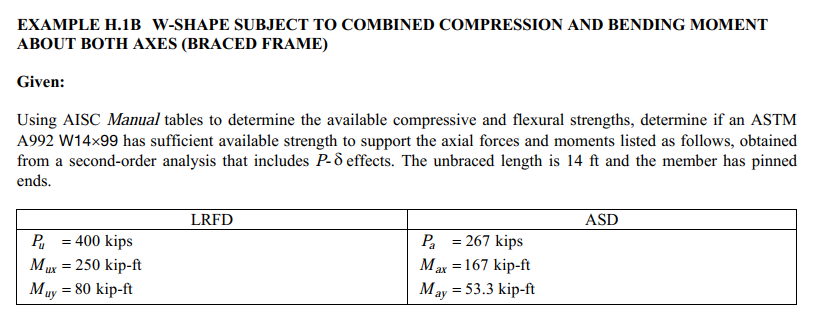

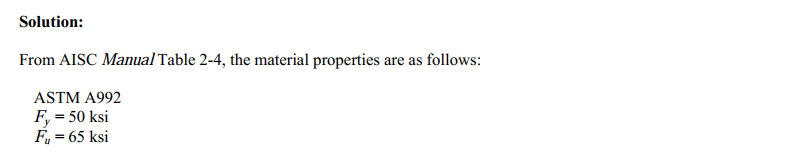

### ------- 사용자 입력부 -------

In [ ]:
## 사용 예시
#######################################################################################
    ####### 공통 입력부 #######
input_path = 'Section Profile.csv'

input_dsgnMode = "LRFD"

input_fy = 344.738 ## 50 ksi
input_fu = 448.159 ## 65 ksi
input_E = 199900 ## 29000

# input_DL = 6.567  ## 휨 검토때
# input_LL = 10.945
# input_length = 10670

input_DL = 622.751 ##140 kips ## 압축 검토때
input_LL = 1868.253 ## 420 kips

input_Pu = 1779 ## kN (400 kip)
input_Mux = 338.954 ## kN*m
input_Muy = 108.465 ## kN*m
input_length = 4267 ## 14 ft

    ####### 휨 입력부 #######
input_cb_mode = "Cb고려"
input_table_mode = "continuous"
input_brace_idx = 2

    ####### 압축 입력부 #######
input_Comp_mode = "recommended" ### 압축 유효길이 팩터 테이블 산정 모드
input_cond = "d"  ### 압축 유효길이 팩터 테이블 상 지점 조건
input_effLength = [4267] ### 압축 유효길이

    ####### 인장 입력부 #######
input_dia_bolt=20
input_length_bolt=228
input_n_bolt=4
input_gap_bolt=2

# input_dia_bolt = input_length_bolt = input_n_bolt = input_gap_bolt = None

#######################################################################################

### -----------------------------------

### 0. 단면 정보 import (사용부)

In [ ]:
dfSectionProfile = importCSV(input_path)
dfSectionProfile.remove(dfSectionProfile[0])
dfSectionProfile[0]

In [ ]:
dfSectionProfile

### 1. 단면 자료형 Setter (사용부)

In [ ]:
# targetSection = makeSectionForm(dfSectionProfile[160])
_targetSection = list(filter(lambda x: makeSectionForm(x).ID == "W16X100", dfSectionProfile))[0]
targetSection = makeSectionForm(_targetSection)
targetSection

### ----------------------------------------------------------중략----------------------------------------------------------

#### 2. 단면 속성 Setter (사용부)

In [ ]:
sProp = setSectionProp(targetSection)
sProp

#### 3. 재료 속성 Setter (사용부)

In [ ]:
mProp = setMaterialProp(input_fy, input_fu, input_E)
mProp 

#### 4. 디자인 베이스 Setter (사용부)

In [ ]:
rqStr = setRequiredStrength(input_DL, input_LL, input_Pu, input_Mux, input_Muy)

dBase = setDesignBase(input_dsgnMode, rqStr, input_length, "usePuMu")
dBase

#### 5. 서브 디자인 베이스 Setter (사용부)

In [ ]:
mkSubBaseColl = namedtuple('subBaseColl', 'fBase, cBase, tBase, comBase')

fBase = setFlexureBase(input_cb_mode, input_table_mode, input_brace_idx)
cBase = setCompressureBase(input_Comp_mode, input_cond, *input_effLength)
tBase = setTensileBase(input_dia_bolt, input_length_bolt, input_n_bolt, input_gap_bolt)
comBase = setCombinedBase(cBase, fBase)

subBaseColl = mkSubBaseColl(fBase=fBase, cBase=cBase, tBase=tBase, comBase=comBase)
subBaseColl

#### 6.a, b, c. 서브 디자인 결과 Checker (사용부)

In [ ]:
mkSubCheckColl = namedtuple('subCheckColl', 'fCheck, cCheck, tCheck, comCheck')

subCheckColl = mkSubCheckColl(fCheck=checkFlexure, cCheck=checkCompressure, tCheck=checkTensile, comCheck=checkCombined)

subCheckColl

#### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 7. 디자인 결과 Checker (사용부)

In [ ]:
res = checkDesignResult(input_dsgnMode, sProp, mProp, dBase, subBaseColl, subCheckColl)
res

# print(showResult(res, 'checkFlexure'))
# print(showResult(res, 'checkCompressure'))
# print(showResult(res, 'checkTensile'))
# print(showResult(res, 'checkCombined'))

showResult(res, 'all')

## <<< 다중 부재 검토 Mode >>>

### ------- 사용자 입력부 -------

In [ ]:
## 사용 예시
#######################################################################################
    ####### 공통 입력부 #######
input_path = 'Section Profile.csv'

input_dsgnMode = "LRFD"

input_fy = 344.738 ## 50 ksi
input_fu = 448.159 ## 65 ksi
input_E = 199900 ## 29000

# input_DL = 6.567  ## 휨 검토때
# input_LL = 10.945
# input_length = 10670

input_DL = 622.751 ##140 kips ## 압축 검토때
input_LL = 1868.253 ## 420 kips

input_Pu = 1779 ## kN (400 kip)
input_Mux = 338.954 ## kN*m
input_Muy = 108.465 ## kN*m
input_length = 4267 ## 14 ft

    ####### 휨 입력부 #######
input_cb_mode = "Cb고려"
input_table_mode = "continuous"
input_brace_idx = 2

    ####### 압축 입력부 #######
input_Comp_mode = "recommended" ### 압축 유효길이 팩터 테이블 산정 모드
input_cond = "d"  ### 압축 유효길이 팩터 테이블 상 지점 조건
input_effLength = [4267] ### 압축 유효길이

    ####### 인장 입력부 #######
# input_dia_bolt=20
# input_length_bolt=228
# input_n_bolt=4
# input_gap_bolt=2

input_dia_bolt = input_length_bolt = input_n_bolt = input_gap_bolt = None

#######################################################################################

### -----------------------------------

### 0 ~ 1. 다중 단면 자료형 세팅

In [ ]:
## 여기서 makeSectionForms는 데이터를 저장하지 않고 함수 객체를 저장한다. C#, JAVA에서의 Delegate와 동일
makeSectionForms = lambda _list: go\
(
    _list,
    map(makeSectionForm),
    
list)

In [ ]:
#### 0. 단면 정보 import
dfSectionProfile = importCSV(input_path)
dfSectionProfile.remove(dfSectionProfile[0])

#### 1. 단면 자료형 setter
targetSections = makeSectionForms(dfSectionProfile)
# targetSections

### 2 ~ 6. 각종 Setter들 및 Checker들 고정 조건 세팅

In [ ]:
### 고정 조건 세팅

    #### 3. 재료속성
mProp = setMaterialProp(input_fy, input_fu, input_E)

    #### 4. 디자인 베이스 setter
rqStr = setRequiredStrength(input_DL, input_LL, input_Pu, input_Mux, input_Muy)

dBase = setDesignBase(input_dsgnMode, rqStr, input_length, "usePuMu")

    #### 5. 서브 디자인 베이스 setter
mkSubBaseColl = namedtuple('subBaseColl', 'fBase, cBase, tBase, comBase')

fBase = setFlexureBase(input_cb_mode, input_table_mode, input_brace_idx)
cBase = setCompressureBase(input_Comp_mode, input_cond, *input_effLength)
tBase = setTensileBase(input_dia_bolt, input_length_bolt, input_n_bolt, input_gap_bolt)
comBase = setCombinedBase(cBase, fBase)

subBaseColl = mkSubBaseColl(fBase=fBase, cBase=cBase, tBase=tBase, comBase=comBase)

    #### 6.a~d 서브디자인 checker
mkSubCheckColl = namedtuple('subCheckColl', 'fCheck, cCheck, tCheck, comCheck')

subCheckColl = mkSubCheckColl(fCheck=checkFlexure, cCheck=checkCompressure, tCheck=checkTensile, comCheck=checkCombined)


subBaseColl

### 디자인 결과 Checker 용 합성함수 제조

In [ ]:
### 가변 조건 검토를 위한 함수 합성

multiChecker1 = lambda _list: go\
(
    _list,
    map(makeSectionForm),
    map(setSectionProp),
    map(lambda x: checkDesignResult(input_dsgnMode, x, mProp, dBase, subBaseColl, subCheckColl)),
    filter(lambda x: x.result_comp.Result == "O.K." ),
    map(lambda x: showResult(x, "checkCombined")),
    
list)

In [ ]:
multiChecker1(targetSections)

In [ ]:
### 가변 조건 검토를 위한 함수 합성

multiChecker2 = lambda _list: go\
(
    _list,
    map(makeSectionForm),
    map(setSectionProp),
    map(lambda x: checkDesignResult(input_dsgnMode, x, mProp, dBase, subBaseColl, subCheckColl)),
    filter(lambda x: x.result_flx.Result == "N.G." ),
    map(lambda x: showResult(x, "checkCombined")),
    
list)

In [ ]:
multiChecker2(targetSections)

In [ ]:
def showGraph(y_value, threshold=None):
    x = range(len(y_value))
    y = y_value
    fig, ax = plt.subplots(figsize=(20,20))
    if threshold:
        ax.axhline(threshold, 0, 1, color='red', linestyle='--', linewidth=2)

    plt.plot(x,y,'or')
    plt.show()
    
#     return y_value

In [ ]:
multiChecker_forGraph = lambda _list: go\
(
    _list,
    map(makeSectionForm),
    map(setSectionProp),
    map(lambda x: checkDesignResult(input_dsgnMode, x, mProp, dBase, subBaseColl, subCheckColl)),
#     filter(lambda x: x.result_flx.Result == "O.K." ),
#     map(lambda x: x.result_flx.NomStr),list,
#     map(lambda x: x.result_flx.ReqStr),list,
    map(lambda x: x.result_flx.ReqStr/x.result_flx.NomStr),list,

#     showGraph,
    lambda x: showGraph(x, 1)
)

multiChecker_forGraph(targetSections)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [16]:
def m100(a):
    return a * 100

In [17]:
def p5000(a):
    return a + 5000

In [19]:
x = 1004

res1 = m100(x)

In [20]:
p5000(res1)

105400

In [21]:
p5000(m100(x))


105400

In [23]:
더하기5000 = p5000

In [25]:
더하기5000(100)

5100

In [ ]:
lambda _list: go\
(_list,
    filter(lambda a: not a % 2),
    filter(lambda a: not a % 4),
    map(lambda a: a ),
    reduce(add)
)